# Header

- [Backpropagation through the void](#Backpropagation-through-the-void)
- [Continuous relaxations of discrete variables](#Continuous-relaxations-of-discrete-variables)
- [Examples](#Examples)
    - [Linear model](#Linear-model)
    - [Coin Tosses](#Coin-Tosses)
    - [Toy model w/ REBAR](#Toy-model-w/-REBAR)


In [1]:
%matplotlib inline
# disable rescaling the figure, to gain tighter control over the result
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [140]:
from chmp.ds import reload

reload('chmp.ds', 'chmp.bayes', 'chmp.ml', 'chmp')
from chmp import bayes
from chmp.ds import mpl_set, path, axtext, get_color_cycle, define, caption, edges
from chmp.ml import get_shape

import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import tensorflow as tf

floatx = tf.float32

# Backpropagation through the void

[Open Review](https://openreview.net/forum?id=SyzKd1bCW&noteId=SyzKd1bCW) | 
[arxiv](https://arxiv.org/abs/1711.00123)

Problem statement: optimize the parameters of a distribution to maximize an expectation

Objective

$$
    \theta^\star = \mathrm{argmax}_\theta \mathbb{E}_{b \sim p(b|\theta)} \left[ f(b) \right]
$$


## Score function trick

Also called REINFORCE.

$$
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big] =
    \mathbb{E}_{p(b|\theta)} \big[ f(b) \frac{\partial}{\partial \theta} \log p(b|\theta) \big] 
$$


## Reparametrization Trick

Assume $p(b|\theta)$ can be expressed as the determinstic transform of non-parametrized random variable $\epsilon \sim p(\epsilon), T(\epsilon|\theta) \sim p(b|\theta)$.

$$
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big] =
    \mathbb{E}_{p(\epsilon)} \big[ \frac{\partial}{\partial \theta}  f(T(\epsilon|\theta)) \big]
$$

## LAX

Mix score function and reparametrization for non-differentiable $f$, but reparametrizable $b$. Introduce control-variates $c_\phi(b)$.

$$
\begin{align}
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big]
    &= \mathbb{E}_{p(b|\theta)} \big[ 
        g_\mathrm{score}[f] - g_\mathrm{score}[c_\phi] + g_\mathrm{reparam}[c_\phi] 
    \big]
\\
    &= \mathbb{E}_{p(\epsilon)} \big[ 
        (f(T(\epsilon, \theta)) - c_\phi(T(\epsilon, \theta))) 
        \frac{\partial}{\partial \theta} \log p(T(\epsilon, \theta)|\theta) +
        \frac{\partial}{\partial \theta} c_\phi(T(\epsilon, \theta)|\theta)
    \big]
\end{align}
$$

## RELAX

Introduce continuous relaxation in addition to LAX for non-differentiable $f$, but non-reparametrizable $b$.

Write the sampling process as the deterministic transformation ($H$) of a continuous variable ($z$):

$$
\begin{align}
    z &\sim p(z |\theta) \\
    b &= H(z) \sim p(b |\theta) \\
    \tilde{z} &\sim p(\tilde{z}|b, \theta)
\end{align}
$$

The gradient estimates is then written as:
$$
\begin{align}
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big]
    &= \mathbb{E}_{p(b|\theta)} \big[ 
        g_\mathrm{score}[f] - g_\mathrm{score}[c_\phi(\tilde{z})] 
        + g_\mathrm{reparam}[c_\phi] 
        - g_\mathrm{reparam}[c_\phi(\tilde{z})]
    \big]
\end{align}
$$

The last term corrects the error made, when using the $\tilde{z}$ in the score function estimator. By using $\tilde{z}$ in score function estimator, RELAX reduces to the reparametrization trick for $c_\phi = f$.
Note, that in this expression $b$ is fixed throughout. Therefore when backpropagating through $\tilde{z}$, no gradient through $b$ is taken.
The estimator is unbiased as can be shown via:

$$
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big] = 
    \mathbb{E}_{p(z|\theta)} \big[
        (f(b) - c_\phi(\tilde{z})) \frac{\partial}{\partial \theta} \log p(b|\theta) +
        \frac{\partial}{\partial \theta} c_\phi(z) -
        \frac{\partial}{\partial \theta} c_\phi(\tilde{z})
    \big]
$$

Both $p(z| \theta)$ and $p(\tilde{z}|b, \theta)$ are re-parametrizable.

## How to choose the control variate?

The paper explorese two options: 

- learning the control variate by minimizing a one-sample estimate of the variance
- using a smoothed version of the original loss, i.e., replacing all categoricla variables with smoothed versions sampled via the Gumbel-softmax trick. In that case, the temperature can still be learned to minimize the variance.

## Summary

|              |f diff.       |f non-diff.|
|--------------|--------------|-----------|
|b reparam.    |reparam. trick|    LAX    |
|b non-reparam.|    RELAX     |   RELAX   |


# Continuous relaxations of discrete variables

## Relaxation of binary variables

[REBAR: Low-variance, unbiased gradient estimates for discrete latent variable models](https://arxiv.org/abs/1703.07370): Binary relaxation with control variates for variance reduction.

Based on sampling approach, $b = H(p - u)$, with $H(x) = 1\;\mathrm{if}\;x > 0\;\mathrm{else}\;0$ and $u \sim \mathrm{Uniform(0, 1)}$.

Given the inequality $u < p$, any monotonic transformation does not change the outcome. Here use the logit transform $\mathrm{logit}(p) = \log \frac{p}{1 - p}$. This gives $\mathrm{logit}(u) < \mathrm{logit}(p)$. Observe that for $u \sim \mathrm{Uniform(0, 1)}$:

$$
    -\mathrm{logit}(u) = \mathrm{logit}(1 - u) = \mathrm{logit}(u^\prime),
$$

with $u^\prime \sim \mathrm{Uniform}(0, 1)$.

Thefore we can sample $b$ as

$$
    b = H(\log \frac{p}{1 - p} + \log \frac{u}{1 - u}).
$$

Finally, the Heavyside step function can be relaxed into a sigmoid to allow backprop through the binary variable. This results in a low variance, but biased estimator. As an alternative, the continuous relaxation can be used as a control variate. This will result in an unbiased estimator with low variance.

To sample $z| b$, note that

$$
\begin{align}
    z(u^\prime) &= 0
\\
    u^\prime = 1 - p
\end{align}
$$

By analogy to rejection sampling, one finds that $u \sim \mathrm{Uniform}(1 - p, 1)$ for $b = 1$ and 
$u \sim \mathrm{Uniform}(0, 1 - p)$ for $b = 0$. Thereby $z$ can be sampled as:

$$
\begin{align}
    z = \mathrm{logit}(p) + b \mathrm{logit}(1 - v p) + (1 - b) \mathrm{logit}(v(1 - p)),
\end{align}
$$

with $v \sim \mathrm{Uniform}(0, 1)$.


In [4]:
z = np.linspace(-3, 3, 100)

In [5]:
u = np.random.uniform(size=(z.size, 1000))
u = np.clip(u, 1e-9, 1 - 1e-9)

In [6]:
theta = 1.0 / (1.0 + np.exp(-z[:, None]))
theta = theta + 0 * u

In [7]:
actual_b = (z[:, None] + np.log(u / (1 - u))) > 0
actual_b_mean = np.mean(actual_b, axis=1)
actual_b_std = np.std(actual_b, axis=1)

expected_b_mean = 1.0 / (1.0 + np.exp(-z))
expected_b_std = np.sqrt(expected_b_mean * (1.0 - expected_b_mean))

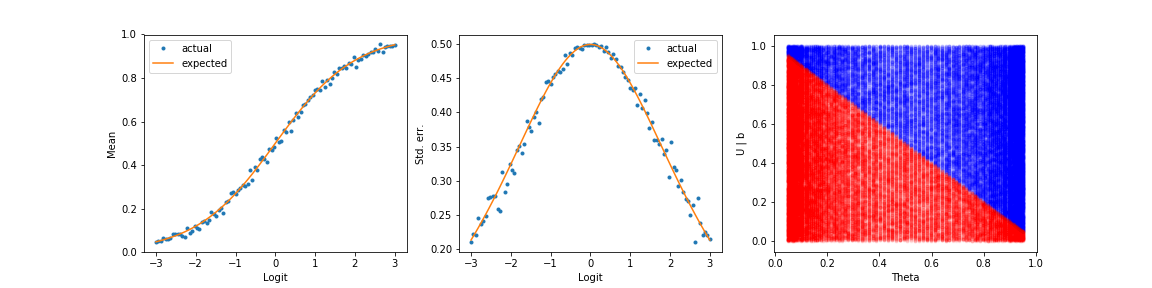

In [8]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(z, actual_b_mean, ".", label='actual')
plt.plot(z, expected_b_mean, label='expected')
mpl_set(legend=True, xlabel='Logit', ylabel='Mean')

plt.subplot(1, 3, 2)
plt.plot(z, actual_b_std, '.', label='actual')
plt.plot(z, expected_b_std, label='expected')
mpl_set(legend=True, xlabel='Logit', ylabel='Std. err.')

plt.subplot(1, 3, 3)
plt.scatter(theta[actual_b == 1], u[actual_b == 1], alpha=0.05, marker='.', color='b')
plt.scatter(theta[actual_b == 0], u[actual_b == 0], alpha=0.05, marker='.', color='r')
mpl_set(xlabel='Theta', ylabel='U | b')

## Continous Relaxation of categorical variables

Sample $z$ as

$$
    z_i = log \pi_i - \log (-\log u_i)
$$

Then categorical can be determined as $b = \mathrm{argmax}\; z_i$.

To sample $z|b$, note that we have to ensure $z_b > z_i\; \forall i \neq b$. This leads to the following condition on the $u_i$:

$$
\begin{align}
    z_i &< z_b \\
    \log \theta_i + g_i &< \log \theta_b + g_b \\
    \log \frac{\theta_i}{\theta_b} &< \log \frac{\log u_i}{\log u_b} \\
    \frac{\theta_i}{\theta_b} &< \frac{\log u_i}{\log u_b} \\
    \frac{\theta_i}{\theta_b} \log u_b &> \log u_i \\
    u_b^{\theta_i / \theta_b} &> u_i
\end{align}
$$

This can easily be sampled setting:

$$
    u_i := \begin{cases}
        u_i & \text{if $i = b$} \\
        u_i u_b^{\theta_i / \theta_b}
    \end{cases}
$$

This result can be found in app. B of "Backporpagation through the void".

Note, that $u_b$ is **not** uniformly distributed, when conditioned on $b$ being the maximum. In that case one finds:

$$
\begin{align}
    p(u_b) 
        &\propto \prod_{i \neq b} \int_0^1 \mathrm{d} u_i\; \Theta(u_b^{\theta_i / \theta_b} - u_i) \\
        &= \prod_{i \neq b} u_b^{\theta_i / \theta_b} \\
        &= u_b^{\sum_{i \neq b} \theta_i / \theta_b} \\
        &= u_b^{(1 - \theta_b) / \theta_b} \\
    p(u_b) &\sim Beta\left( 1 + \frac{1 - \theta_b}{\theta_b}, 1 \right).
\end{align}
$$

Note, that $Beta(1 + \alpha, 1)$ is reparametrizable by using the inverse CDF trick:

$$
\begin{align}
    Beta(1 + \alpha, 1) &= \alpha x^\alpha \\
    \int_0^{z}\mathrm{d}u\; \alpha x^{\alpha} &= z^{\alpha + 1} = u \\
    z &= u^{1/(\alpha + 1)}
\end{align}
$$

In [9]:
np.random.seed(13)
pi = np.random.dirichlet(alpha=[0.4] * 3)

In [10]:
triangle = np.asarray([
    (0, 0), 
    (1, 0), 
    (np.cos(2 * np.pi / 6), np.sin(2 * np.pi / 6)),
])

T = np.asarray([
    triangle[:, 0],
    triangle[:, 1],
    np.ones(3),
])

In [11]:
def softmax(x, axis=-1):
    xmax = np.max(x, axis=axis, keepdims=True)
    x = x - xmax
    x = np.exp(x)
    x = x / np.sum(x, axis=axis, keepdims=True)
    return x

In [12]:
np.random.seed(42)
u = np.random.uniform(size=(3, 2000))
z = np.log(pi[:, None]) - np.log(-np.log(u))

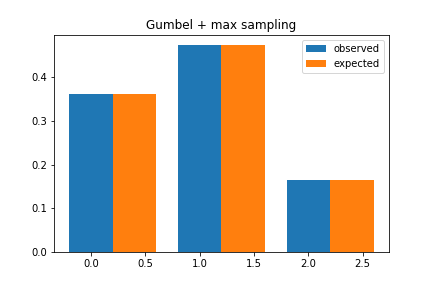

In [13]:
plt.title('Gumbel + max sampling')
plt.bar(np.arange(3), np.bincount(np.argmax(z, axis=0)) / z.shape[1], width=0.4, label='observed')
plt.bar(np.arange(3) + 0.4, pi, width=0.4, label='expected')
plt.legend()
pass

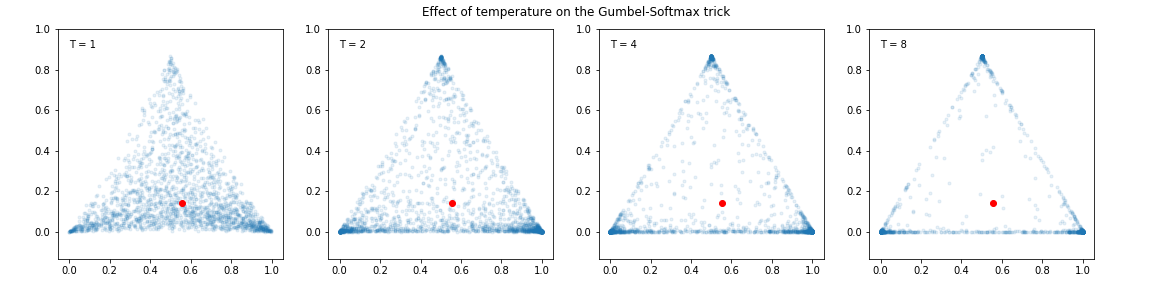

In [14]:
@define
def _plot():
    plt.figure(figsize=(16, 4))
    plt.subplots_adjust(top=0.90, bottom=0.1, left=0.05, right=0.95)
    for idx, temp in enumerate([1, 2, 4, 8]):
        x, y, _ = np.dot(T, pi)
        z_x, z_y, _ = np.dot(T, softmax(temp * z[:, :2000], axis=0))

        plt.subplot(1, 4, 1 + idx)
        plt.scatter(z_x, z_y, alpha=0.1, marker='.')
        plt.scatter([x], [y], color='r')
        axtext(0.05, 0.95, f'T = {temp}', va='top', ha='left')
        plt.axis('equal')

    plt.suptitle('Effect of temperature on the Gumbel-Softmax trick')

In [33]:
np.random.seed(42)
u = np.random.uniform(size=(3, 100000))

z = np.log(pi[:, None]) - np.log(-np.log(u))

reject_u_given2 = u[:, np.argmax(z, axis=0) == 2]

scaled_u_given2 = np.copy(u)
scaled_u_given2[2, :] = np.random.beta(1.0 + (1.0 - pi[2]) / pi[2], 1, size=u.shape[1])

scaled_u_given2[0, :] = scaled_u_given2[0, :] * (scaled_u_given2[2, :] ** (pi[0] / pi[2]))
scaled_u_given2[1, :] = scaled_u_given2[1, :] * (scaled_u_given2[2, :] ** (pi[1] / pi[2]))

reject_z_given2 = np.log(pi[:, None]) - np.log(-np.log(reject_u_given2))
reject_b_given2 = softmax(reject_z_given2, axis=0)

scaled_z_given2 = np.log(pi[:, None]) - np.log(-np.log(scaled_u_given2))
scaled_b_given2 = softmax(scaled_z_given2, axis=0)

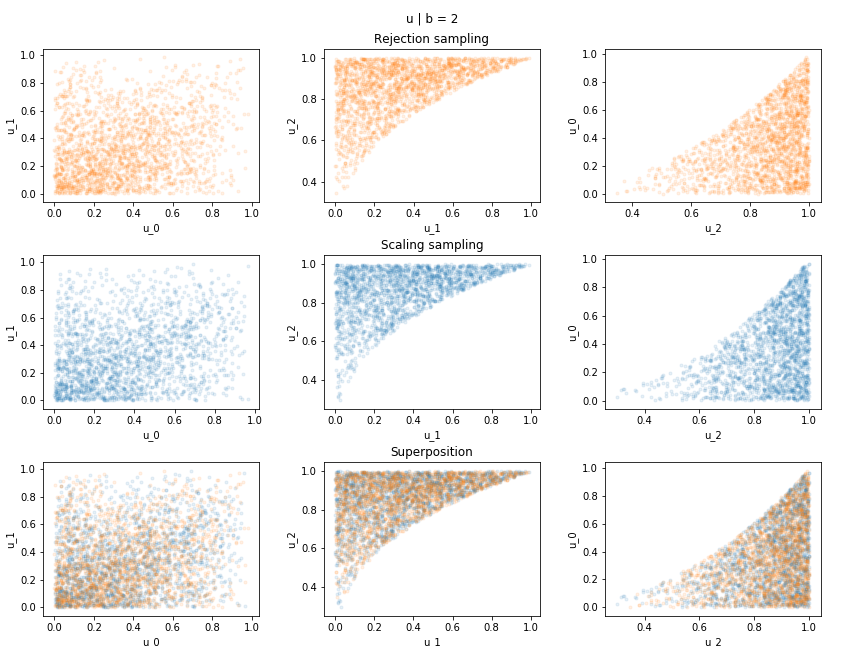

In [34]:
@define
def _plot():
    blue, green = get_color_cycle(2)
    N = 2000
    
    plt.figure(figsize=(12, 9))
    plt.suptitle('u | b = 2')
    plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.925, bottom=0.05, right=0.95, left=0.05)
    for idx in range(3):
        plt.subplot(3, 3, 1 + idx)
        plt.scatter(
            reject_u_given2[(idx + 0) % 3, :N], reject_u_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=green,
        )
        mpl_set(xlabel=f'u_{(idx + 0) % 3}', ylabel=f'u_{(idx + 1) % 3}')
        if idx == 1:
            plt.title('Rejection sampling')
        
        plt.subplot(3, 3, 4 + idx)
        plt.scatter(
            scaled_u_given2[(idx + 0) % 3, :N], scaled_u_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=blue,
        )
        mpl_set(xlabel=f'u_{(idx + 0) % 3}', ylabel=f'u_{(idx + 1) % 3}')
        if idx == 1:
            plt.title('Scaling sampling')


        plt.subplot(3, 3, 7 + idx)
        plt.scatter(
            scaled_u_given2[(idx + 0) % 3, :N], scaled_u_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=blue,
        )
        plt.scatter(
            reject_u_given2[(idx + 0) % 3, :N], reject_u_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=green,
        )
        mpl_set(xlabel=f'u_{(idx + 0) % 3}', ylabel=f'u_{(idx + 1) % 3}')
        if idx == 1:
            plt.title('Superposition')

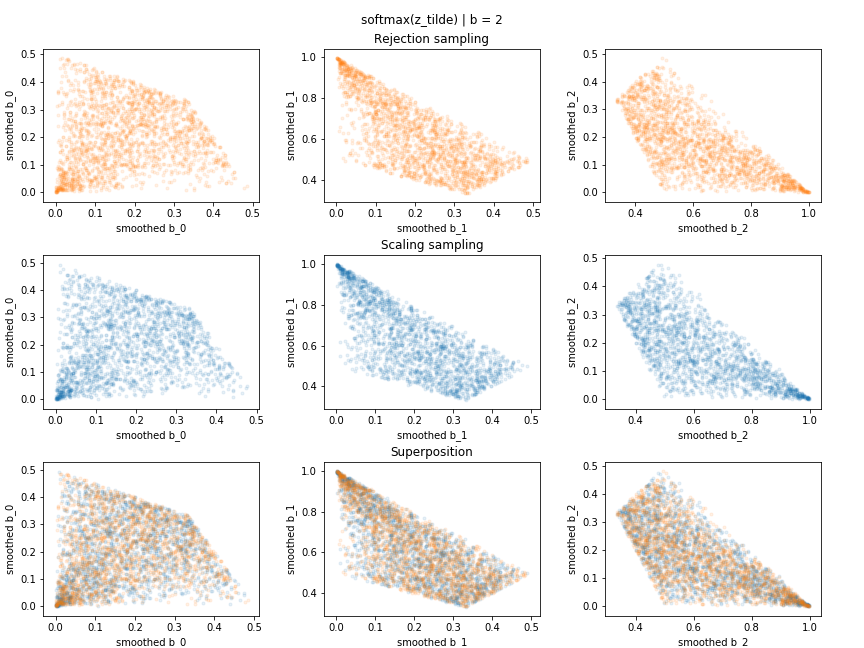

In [35]:
@define
def _plot():
    blue, green = get_color_cycle(2)
    N = 2000
    
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.925, bottom=0.05, right=0.95, left=0.05)
    plt.suptitle('softmax(z_tilde) | b = 2')
    for idx in range(3):
        plt.subplot(3, 3, 1 + idx)
        plt.scatter(
            reject_b_given2[(idx + 0) % 3, :N], reject_b_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=green,
        )
        mpl_set(xlabel=f'smoothed b_{(idx + 0) % 3}', ylabel=f'smoothed b_{(idx + 0) % 3}')
        if idx == 1:
            plt.title('Rejection sampling')

        plt.subplot(3, 3, 4 + idx)
        plt.scatter(
            scaled_b_given2[(idx + 0) % 3, :N], scaled_b_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=blue,
        )
        mpl_set(xlabel=f'smoothed b_{(idx + 0) % 3}', ylabel=f'smoothed b_{(idx + 0) % 3}')
        if idx == 1:
            plt.title('Scaling sampling')


        plt.subplot(3, 3, 7 + idx)
        plt.scatter(
            scaled_b_given2[(idx + 0) % 3, :N],  scaled_b_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=blue,
        )
        plt.scatter(
            reject_b_given2[(idx + 0) % 3, :N], reject_b_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=green,
        )
        mpl_set(xlabel=f'smoothed b_{(idx + 0) % 3}', ylabel=f'smoothed b_{(idx + 0) % 3}')
        if idx == 1:
            plt.title('Superposition')

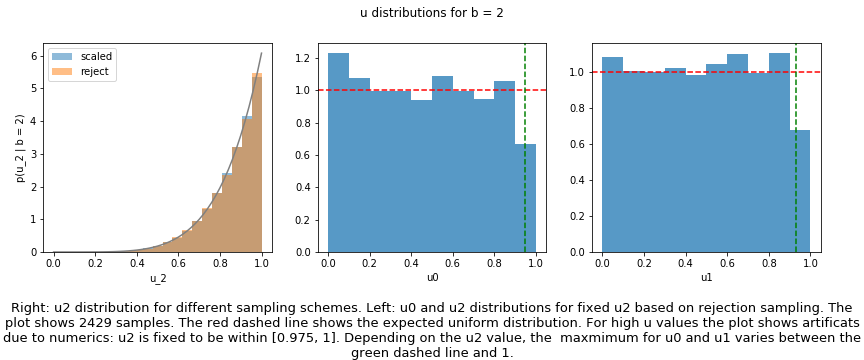

In [36]:
@define 
def _plot():
    blue, green = get_color_cycle(2)
    cutoff = 0.975
    u1, u2, _ = reject_u_given2[:, (cutoff < reject_u_given2[2, :])]
    u = np.linspace(0, 1, 51)
    
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.3)
    plt.suptitle(f'u distributions for b = 2')
    
    plt.subplot(1, 3, 1)
    plt.hist(
        scaled_u_given2[2, :], 
        bins=21, range=(0, 1), alpha=0.5, normed=True, color=blue, label='scaled',
    )
    plt.hist(
        reject_u_given2[2, :], 
        bins=21, range=(0, 1), alpha=0.5, normed=True, color=green, label='reject',
    )
    plt.plot(
        u, stats.distributions.beta(1 + (1 - pi[2]) / pi[2], 1).pdf(u),
        c='0.5',
    )
    mpl_set(legend=True, xlabel='u_2', ylabel='p(u_2 | b = 2)')
    
    plt.subplot(1, 3, 2)
    plt.hist(u1, bins=10, range=(0, 1), normed=True, alpha=0.75)
    plt.axhline(y=1.0, ls='--', color='r')
    plt.axvline(x=cutoff ** (pi[0] / pi[2]), color='g', ls='--')
    mpl_set(xlabel='u0')
    
    plt.subplot(1, 3, 3)
    plt.hist(u2, bins=10, range=(0, 1), normed=True, alpha=0.75)
    plt.axhline(y=1.0, ls='--', color='r')
    plt.axvline(x=cutoff ** (pi[1] / pi[2]), color='g', ls='--')
    mpl_set(xlabel='u1')
    
    caption(f'''
        Right: u2 distribution for different sampling schemes.
        Left: u0 and u2 distributions for fixed u2 based on rejection sampling. 
        The plot shows {len(u1)} samples.
        The red dashed line shows the expected uniform distribution. 
        For high u values the plot shows artificats due to numerics: 
        u2 is fixed to be within [{cutoff}, 1].
        Depending on the u2 value, the  maxmimum for u0 and u1 varies 
        between the green dashed line and 1.
    ''')

# Examples

## Linear model

In [641]:
tf.reset_default_graph()

with bayes.Model() as model:
    @model.observe
    def _(s):
        s.x = tf.placeholder(dtype=floatx, shape=[None, 1], name='x')
        s.y = tf.placeholder(dtype=floatx, shape=[None], name='y')
    
    @model.define
    def _(s, lam=0.5):
        s.p.w = tf.distributions.Normal(loc=0.0, scale=1.0 / lam)
        s.p.y = tf.distributions.Normal(loc=tf.squeeze(s.x @ s.w[:, None]), scale=1.0)

    @model.inference
    def _(s):
        _, n_features = get_shape(s.x)
    
        s.q.w = tf.distributions.Normal(
            loc=tf.get_variable('w_loc', shape=[n_features], dtype=floatx),
            scale=tf.nn.softplus(tf.get_variable('w_scale', shape=[n_features], dtype=floatx)),
        )
        
x_, y_ = model['x', 'y']
pred_y_, w_loc_, w_std_ = bayes.build(
    model, lambda y, w: (y.mean(), w.loc, w.scale), 
    latent_strategy=bayes.average_latent,
)
loss_, train_loss_ = bayes.build_reparam_loss(model)
train_ = tf.train.AdamOptimizer(0.05).minimize(train_loss_)

In [642]:
w = np.random.normal(loc=1.0, scale=0.5, size=(100,))
x = np.random.uniform(-5, 5, size=(100, 1))
y = np.random.normal(loc=w * x.reshape(-1), scale=0.2)

In [644]:
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(500):
        _, loss = sess.run((train_, loss_), {x_: x, y_: y})
        losses.append(loss)
    
    pred_y = sess.run(pred_y_, {x_: x})

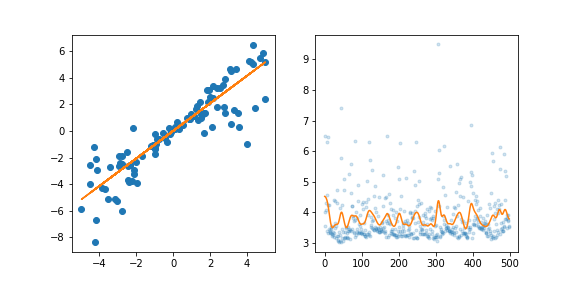

In [645]:
@define
def _plot():
    from scipy.ndimage import gaussian_filter
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)

    c0, c1 = get_color_cycle(2)
    plt.scatter(x, y, color=c0)
    plt.plot(x, pred_y, color=c1)

    plt.subplot(1, 2, 2)
    plt.plot(losses, '.', alpha=0.2, color=c0)
    plt.plot(gaussian_filter(losses, sigma=5), color=c1)

## Coin Tosses

In [646]:
tf.reset_default_graph()

with bayes.Model() as model:
    @model.observe
    def _(s):
        s.y = tf.placeholder(shape=[None], dtype=floatx, name='y')
    
    @model.define
    def _(s):
        s.p.z = tf.distributions.Beta(1.1, 1.1)
        s.p.y = tf.distributions.Bernoulli(probs=s.z)
    
    @model.inference
    def _(s):
        s.q.z = tf.distributions.Beta(
            tf.nn.softplus(tf.get_variable('alpha', initializer=2.0)),
            tf.nn.softplus(tf.get_variable('beta', initializer=2.0)),
        )
        
z_ = tf.placeholder(shape=[None], dtype=floatx, name='z')
loss_, train_loss_ = bayes.build_score_loss(model)
pz_ = bayes.build(model, lambda z: z.prob(z_))
y_ = model['y']

train_ = tf.train.AdamOptimizer(0.01).minimize(train_loss_)

In [647]:
y = np.random.binomial(1, 0.7, size=100)
z = np.linspace(0, 1, 51)

In [648]:
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(500):
        _, loss = sess.run((train_, loss_), {y_: y})
        losses.append(loss)
        
    pz = sess.run(pz_, {z_: z})

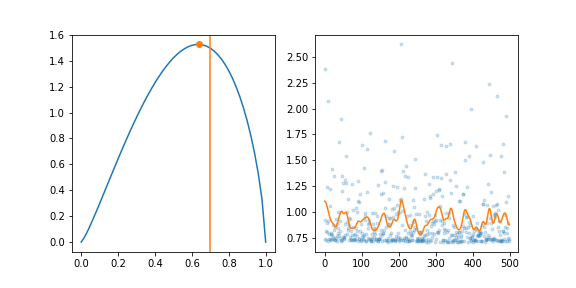

In [649]:
@define
def _plot():
    from scipy.ndimage import gaussian_filter
    
    c0, c1 = get_color_cycle(2)
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(z, pz, color=c0)

    idx = np.argmax(pz)
    plt.plot([z[idx]], [pz[idx]], 'o', color=c1)
    plt.axvline(x=0.7, color=c1)
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, '.', alpha=0.2, color=c0)
    plt.plot(gaussian_filter(losses, sigma=5), color=c1)

## Toy model w/ REBAR

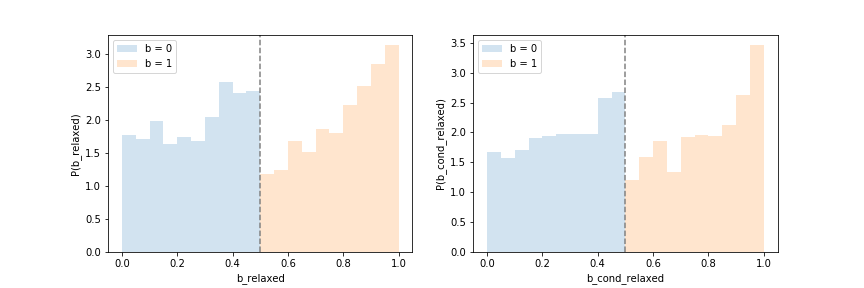

In [650]:
tf.reset_default_graph()
res_ = bayes.relax_bernoulli(tf.distributions.Bernoulli(probs=0.7))

data = []
with tf.Session() as sess:
    for _ in range(2000):
        data.append(sess.run(res_))

data = np.asarray(data)

@define
def _plot():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(data[data[:, 0] == 0, 1], bins=20, range=(0, 1), normed=True, alpha=0.2, label='b = 0')
    plt.hist(data[data[:, 0] == 1, 1], bins=20, range=(0, 1), normed=True, alpha=0.2, label='b = 1')
    plt.axvline(0.5, ls='--', c='0.5')
    mpl_set(xlabel='b_relaxed', ylabel='P(b_relaxed)', legend=True)

    plt.subplot(1, 2, 2)
    plt.hist(data[data[:, 0] == 0, 2], bins=20, range=(0, 1), normed=True, alpha=0.2, label='b = 0')
    plt.hist(data[data[:, 0] == 1, 2], bins=20, range=(0, 1), normed=True, alpha=0.2, label='b = 1')
    plt.axvline(0.5, ls='--', c='0.5')
    mpl_set(xlabel='b_cond_relaxed', ylabel='P(b_cond_relaxed)', legend=True)

In [651]:
tf.reset_default_graph()

with bayes.Model() as model:
    @model.define
    def _(s):
        return (tf.cast(s.z, dtype=tf.float32) - 0.49) ** 2.0
    
    @model.inference
    def _(s):
        s.q.z = tf.distributions.Bernoulli(
            logits=tf.ones(10) * tf.get_variable('theta', initializer=0.5),
        )

loss_, train_loss_ = bayes.build_rebar_loss(model)
train_ = tf.train.AdamOptimizer(1e-1).minimize(train_loss_)

with tf.variable_scope('inference', reuse=tf.AUTO_REUSE):
    theta_ = tf.get_variable('theta')

In [652]:
losses = []
thetas = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1000):
        _, loss, theta = sess.run((train_, loss_, theta_))
        losses.append(loss)
        thetas.append(theta)

losses = np.asarray(losses)
thetas = np.asarray(thetas)

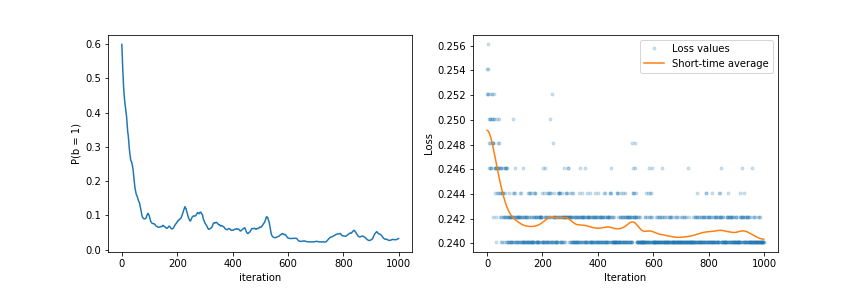

In [657]:
@define 
def _plot():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(1.0 / (1.0 +  np.exp(-thetas)))
    mpl_set(xlabel='iteration', ylabel='P(b = 1)')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, '.', alpha=0.2, label='Loss values')
    plt.plot(gaussian_filter(losses, sigma=20), label='Short-time average')
    mpl_set(xlabel='Iteration', ylabel='Loss', legend=True)

# Relaxation of Categoricals

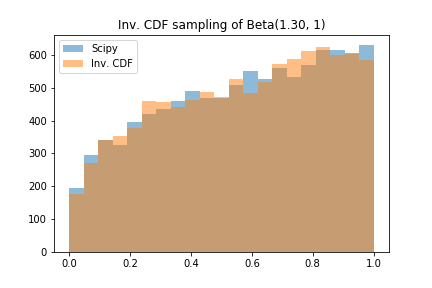

In [141]:
@define
def _plot():
    import scipy.stats as stats

    alpha = 0.3
    plt.hist(
        stats.beta(1 + alpha, 1).rvs(size=10_000),
        bins=21, range=(0, 1), alpha=0.5, label='Scipy',
    )

    plt.hist(
        np.random.uniform(size=10_000) ** (1.0 / (1.0 + alpha)),
        bins=21, range=(0, 1), alpha=0.5, label='Inv. CDF', 
    )
    mpl_set(legend=True, title=f'Inv. CDF sampling of Beta({1 + alpha:.2f}, 1)')

In [142]:
tf.reset_default_graph()
p = tf.distributions.Multinomial(probs=[0.3, 0.2, 0.5], total_count=1.0)
res = bayes.relax_categorical(p)

with tf.Session() as sess:
    data = np.asarray([sess.run(res) for _ in range(10_000)])

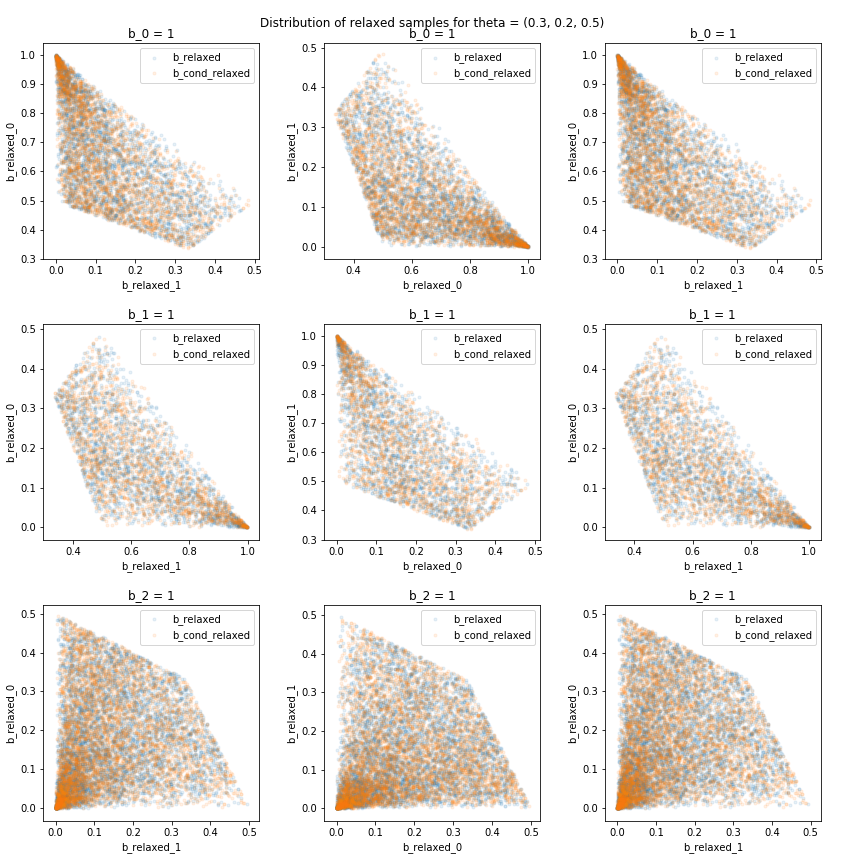

In [143]:
@define
def _plot():
    c0, c1 = get_color_cycle(2)
    
    plt.figure(figsize=(12, 12))
    mpl_set(
        wspace=0.3, hspace=0.3, top=1 - 0.05, bottom=0.05, left=0.05, right=1 - 0.05, 
        suptitle='Distribution of relaxed samples for theta = (0.3, 0.2, 0.5)'
    )
    for i, j in it.product(range(3), range(3)):

        plt.subplot(3, 3, 1 + 3 * i + j)
        plt.scatter(
            data[data[:, 0, i] == 1, 1, (j + 1) % 2], data[data[:, 0, i] == 1, 1, (j + 2) % 2], 
            marker='.', alpha=0.1, color=c0, label='b_relaxed'
        )
        plt.scatter(
            data[data[:, 0, i] == 1, 2, (j + 1) % 2], data[data[:, 0, i] == 1, 2, (j + 2) % 2], 
            marker='.', alpha=0.1, color=c1, label='b_cond_relaxed'
        )
        mpl_set(
            legend=True, 
            xlabel=f'b_relaxed_{(j + 1) % 2}', ylabel=f'b_relaxed_{(j + 2) % 2}', title=f'b_{i} = 1',
        )